### Make plots from remapenrich results.

#### Two plots will show the results from 1) all cells intersection and 2) monocytes intersection

##### 1. set wd and load libraries

In [2]:
library(data.table)
library(ggplot2)
library(ggrepel)
library(dplyr)
library(tidyr)
library(ggrepel)
library(stringr)

setwd("~/HRJ_monocytes/remapenrich/")



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




##### 2. Make plot for ChIP intersect. The original idea was that this one will be for main fig.
##### However, now not using this analysis - just use ATAC predictions and remap (all cells). See below for ATAC predictions.
##### pval on y axis and no. cQTL intersects on x axis.
##### color schemes: use viridis if possible.

In [3]:
### First though, check how wide were the intervals per dataset? For tobias the results are worse. I think they are small.
regions <- fread("./Rev/mono_remap_input_fourSets.txt")
head(regions)

# prepare data - get region lengths per source
regions[, c("TF", "source1") := tstrsplit(category, split = ":")]
regions[source1 == "MaxATACmono", source := "MaxATACmono"]
regions[source1 == "ChIPmono", source := "ChIPmono"]
regions[source1 == "TOBIASmono", source := "TOBIASmono"]
regions[is.na(source), source := "Remap"]

regions[, region_length := end-start]

category,chrom,start,end
<chr>,<chr>,<int>,<int>
STAT3:monocyte,chr1,10057,10300
SMC1A:monocyte,chr1,10061,10302
SMC1:monocyte,chr1,10068,10288
CDK8:monocyte,chr1,10082,10284
CEBPB:monocyte,chr1,10088,10292
MAF:monocyte,chr1,10100,10306


png 
  2

category,chrom,start,end,TF,source1,source,region_length
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
NFIB:TOBIASmono,chrX,274837,274858,NFIB,TOBIASmono,TOBIASmono,21
USF1:TOBIASmono,chrX,274841,274855,USF1,TOBIASmono,TOBIASmono,14
USF2:TOBIASmono,chrX,274841,274855,USF2,TOBIASmono,TOBIASmono,14
RUNX1:TOBIASmono,chrX,274849,274860,RUNX1,TOBIASmono,TOBIASmono,11
HNF4A:TOBIASmono,chrX,274851,274864,HNF4A,TOBIASmono,TOBIASmono,13
HNF4G:TOBIASmono,chrX,274851,274864,HNF4G,TOBIASmono,TOBIASmono,13


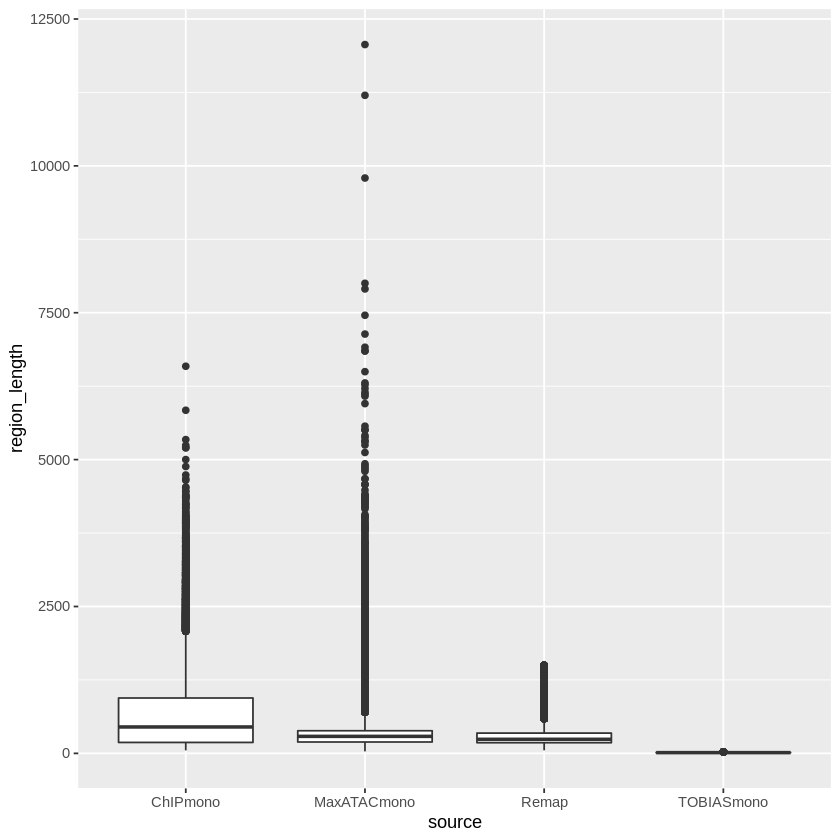

In [3]:
# plot
p <- ggplot(regions, aes(x = source, y = region_length)) + geom_boxplot()
print(p)

pdf(file = "./region_lengths_per_category_in_mono_fourSets.pdf", width = 5, height = 5)
p
dev.off()
# we see that TOBIAS mono is much smaller 
head(regions[source == "TOBIASmono"])

### the below is now included in remapenrich_GUESS_BASE_monoFourSets_exploration.R
# combine TOBIAS + maxATAC, and CTCF CHIP + Remap?
# then in the remapenrich we just give them the same name...
# we can see if this looks OK.

regions[source == "MaxATACmono" | source == "TOBIASmono", Category := "ATAC_prediction"]
regions[source == "Remap" | source == "ChIPmono", Category := "ChIP_seq"]
regions[, category := paste(TF, Category, sep = ":")]

regions_write <- regions[, .(category, chrom, start, end)]

fwrite(regions_write, file = "./Rev/mono_remap_input_fourSets_into2categories.txt", sep = "\t", quote = F, row.names = F, col.names = T)

In [7]:
#################################### WARNING!!! #############################################

######### THIS CHUNK TAKES >30 MINS!!!
### Make a file per TF to then merge in each category.

outdir="./Rev/input_by_TF"
dir.create(outdir)

allTFs <- unique(regions$TF)
for(myTF in allTFs) {
    myTFregions_ATAC <- regions[TF == myTF & category %like% "ATAC_prediction", .(chrom, start, end, category)]
    myTFregions_ChIP <- regions[TF == myTF & category %like% "ChIP_seq", .(chrom, start, end, category)]
    myTFoutname_ATAC <- paste0("mono_remap_input_fourSets_ATAC_", myTF, ".bed")
    myTFoutname_ChIP <- paste0("mono_remap_input_fourSets_ChIP_", myTF, ".bed")

    fwrite(myTFregions_ATAC, file = paste(outdir, myTFoutname_ATAC, sep = "/"), sep = "\t", quote = F, row.names = F, col.names = F)
    fwrite(myTFregions_ChIP, file = paste(outdir, myTFoutname_ChIP, sep = "/"), sep = "\t", quote = F, row.names = F, col.names = F)

}

# merge using bedtools (see script in reampenrich scripts folder, merge_regions_per_TF.sh)
############################################################################################

Warning message in dir.create(outdir):
“'./Rev/input_by_TF' already exists”


In [ ]:
### Read in TF files, merged.

setwd("~/HRJ_monocytes/remapenrich/Rev/input_by_TF")
myfiles <- list.files(pattern = "*.merged.bed")
#myfiles_shorter <- myfiles[1:3]


### need to fix this so that the name of the TF goes into the file.
TFs <- data.table()
for(myfile in myfiles) {
    mybed <- fread(myfile)
    mybed[, V4 := myfile]
    mybed[, V4 := str_replace_all(V4, "mono_remap_input_fourSets_", "")]
    mybed[, V4 := str_replace_all(V4, ".bed.sorted.bed.merged.bed", "")]
    TFs <- rbind(TFs, mybed)
}

head(TFs)

setwd("~/HRJ_monocytes/remapenrich")
fwrite(TFs, file = "./Rev/mono_remap_input_fourSets_into2categories_merged.txt", sep = "\t", quote = F, row.names = F, col.names = F)

# now running remapenrich again using this merged file.

In [12]:
### How many TFs were there in total?
setwd("~/HRJ_monocytes/remapenrich")
#TFs <- fread("./Rev/mono_remap_input_fourSets_into2categories_merged.txt")

#TFs[, c("source", "TF") := tstrsplit(V4, split = "_")]
# all TFs
length(unique(TFs$TF))

# in each category
#library(dplyr)

check <- TFs %>% select(TF, source) %>% distinct() %>% table()
check
check2 <- TFs %>% select(TF, source) %>% distinct() %>% group_by(source) %>% summarise(count = n())

### This table show the no. of TFs in ATAC or in ChIP that went into the analysis.
check2
# 710 ATAC-seq and 14 ChIP-seq


[1] 716

                 source
TF                ATAC ChIP
  AHRARNT            1    0
  ALX1               1    0
  ALX3               1    0
  ALX4               1    0
  AR                 1    0
  ARGFX              1    0
  ARID3A             1    0
  ARID3B             1    0
  ARID5A             1    0
  ARNT               1    0
  ARNT2              1    0
  ARNTHIF1A          1    0
  ARNTL              1    0
  ARX                1    0
  ASCL1              1    0
  ASCL2              1    0
  ASH1L              1    0
  ATF1               1    0
  ATF2               1    0
  ATF3               1    0
  ATF4               1    0
  ATF6               1    0
  ATF7               1    0
  ATOH1              1    0
  ATOH7              1    0
  BACH1              1    0
  BACH1MAFK          1    0
  BACH2              1    0
  BARHL1             1    0
  BARHL2             1    0
  BARX1              1    0
  BARX2              1    0
  BATF               1    0
  BATF3              1  

source,count
<chr>,<int>
ATAC,710
ChIP,14


#### a) Plotting the mono results without merging regions

[1] 96789

[1] 2034

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


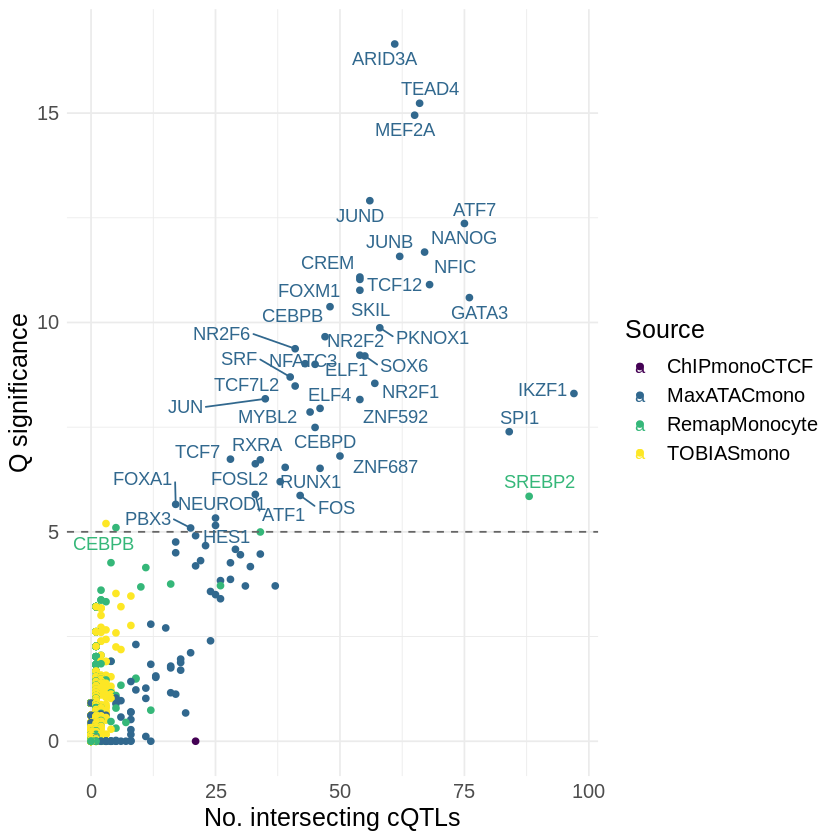

In [4]:
chip <- fread("./Rev/GUESS_BASE_vUniverseSNPs_monoChIP_shuffles100.txt")
chip[, nb.overlaps := as.numeric(nb.overlaps)]

### this data is from four sources: maxatac, chip, tobias, remapmono

chip_plot <- chip[!is.na(q.significance)]
nrow(chip)
nrow(chip_plot)

### Sort out the source and TF names
chip_plot[, c("tf", "source") := tstrsplit(category, split = ":")]
chip_plot[source == "MaxATACmono", Source := "MaxATACmono"]
chip_plot[source == "TOBIASmono", Source := "TOBIASmono"]
chip_plot[source == "ChIPmono", Source := "ChIPmonoCTCF"]
chip_plot[is.na(Source), Source := "RemapMonocyte"]
chip_plot[nb.overlaps >= 5 & q.significance > 5, TF := tf]
chip_plot[is.na(TF), TF := ""]

###

# p.significance is same as -log10p
# q.significance is FDR
p <- ggplot(chip_plot, aes(x = nb.overlaps, y = q.significance, color = Source, label = TF)) + geom_point() + 
xlab("No. intersecting cQTLs") + 
ylab("Q significance")


pdf(file = "./mono_overlaps_fig_plot_minOverlaps5.pdf")
print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     scale_color_viridis_d() + 
     geom_text_repel() + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))
dev.off()

print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     scale_color_viridis_d() + 
     geom_text_repel() + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))

#### b) Plotting the mono results with 128bp intersects

[1] 1871

[1] 1871

[1] "No. of cell types in chip intersect is 276"
[1] "No. of significant TFs in chip intersect is 49"


Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NFIB:TOBIASmono,0,0,0,NA,NA,NA,NA,NA,NA,NA
USF1:TOBIASmono,0,0,0,NA,NA,NA,NA,NA,NA,NA
USF2:TOBIASmono,0,0,0,NA,NA,NA,NA,NA,NA,NA
RUNX1:TOBIASmono,0,0,0,NA,NA,NA,NA,NA,NA,NA
HNF4A:TOBIASmono,0,0,0,NA,NA,NA,NA,NA,NA,NA
HNF4G:TOBIASmono,0,0,0,NA,NA,NA,NA,NA,NA,NA


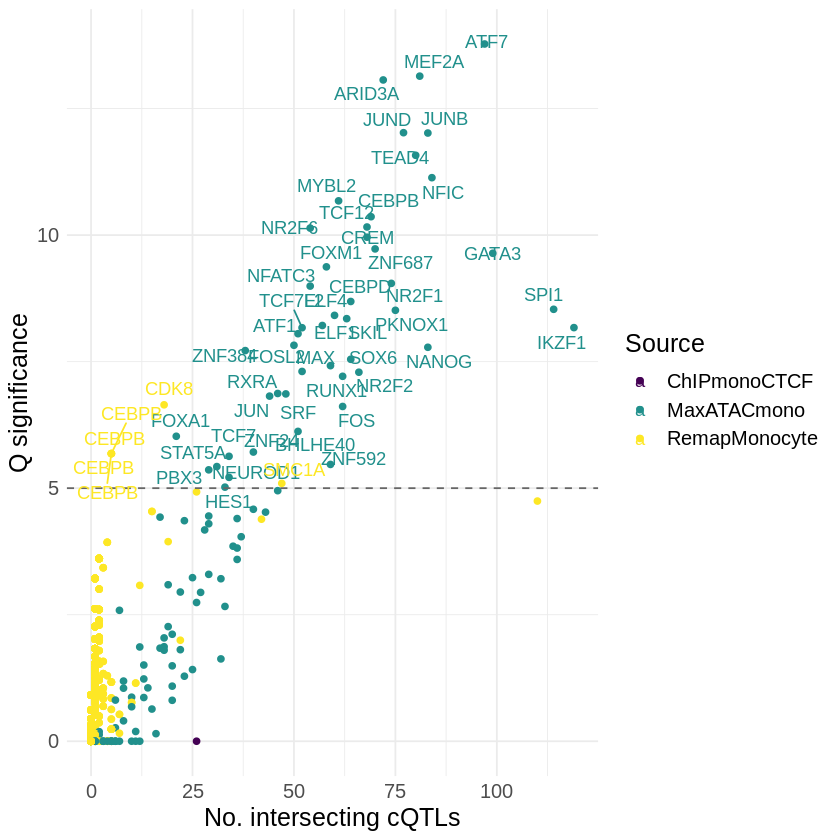

In [6]:
### Look at the results with 128bp +/- regions

chip128 <- fread("./Rev/GUESS_BASE_vUniverseSNPs_monoChIP_shuffles100_128bp.txt")
chip128[, nb.overlaps := as.numeric(nb.overlaps)]

### this data is from four sources: maxatac, chip, tobias, remapmono

chip_plot128 <- chip128[!is.na(q.significance)]
nrow(chip_plot128)
nrow(chip_plot128)

### Sort out the source and TF names
chip_plot128[, c("tf", "source") := tstrsplit(category, split = ":")]
chip_plot128[source == "MaxATACmono", Source := "MaxATACmono"]
chip_plot128[source == "TOBIASmono", Source := "TOBIASmono"]
chip_plot128[source == "ChIPmono", Source := "ChIPmonoCTCF"]
chip_plot128[is.na(Source), Source := "RemapMonocyte"]
chip_plot128[nb.overlaps >= 5 & q.significance > 5, TF := tf]
chip_plot128[is.na(TF), TF := ""]

###

# want to show how many cell types were included in the analysis.
chip_plot128_2 <- as.data.table(chip_plot128 %>% separate_rows(source, sep = ","))
print(paste0("No. of cell types in chip intersect is ", length(unique(chip_plot128_2$source))))
print(paste0("No. of significant TFs in chip intersect is ", length(unique(chip_plot128_2[q.significance > 5 & nb.overlaps >=5, tf])))) # 49


# p.significance is same as -log10p
# q.significance is FDR
p <- ggplot(chip_plot128_2, aes(x = nb.overlaps, y = q.significance, color = Source, label = TF)) + geom_point() + 
xlab("No. intersecting cQTLs") + 
ylab("Q significance")


pdf(file = "./mono_overlaps_fig_plot_minOverlaps5_128bp.pdf")
print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     scale_color_viridis_d() + 
     geom_text_repel() + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))
dev.off()

print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     scale_color_viridis_d() + 
     geom_text_repel() + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))


### Now none of the TOBIAS regions are sig. Probably this is still due to size.

head(chip128[category %like% "TOBIASmono"]) # all NA - probably bc much smaller?

### Need to think about this as well - probably means we should combine the regions properly for TOBIAS and MaxATAC??

#### c) Plotting the mono results with regions that have been merged between the sources. 

Firstly the quick and dirty approach

category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARID3A:ATAC_prediction,61,15.96,0.0012782097,1.934349,17.71509,1.927142e-18,15.92455,1.189733e-16,14.85535,1.395251e-15
TEAD4:ATAC_prediction,66,19.69,0.0014285096,1.745003,16.25129,5.606748e-17,14.46589,3.420640e-15,13.39155,4.059286e-14
MEF2A:ATAC_prediction,65,19.59,0.0014562889,1.730322,15.82028,1.512570e-16,14.03997,9.120782e-15,12.96055,1.095100e-13
JUND:ATAC_prediction,57,17.46,0.0007322901,1.706908,13.76424,1.720923e-14,11.98894,1.025787e-12,10.90450,1.245948e-11
ATF7:ATAC_prediction,75,27.79,0.0014410883,1.432325,13.41621,3.835189e-14,11.64588,2.260056e-12,10.55647,2.776677e-11
CEBPB:ChIP_seq,60,19.42,0.0009372950,1.627419,13.39450,4.031817e-14,11.62907,2.349232e-12,10.53476,2.919035e-11


[1] 641

[1] 641

[1] "No. of significant TFs in chip intersect is 43"


category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value,tf,source,TF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
CTCF:ATAC_prediction,8,5.64,1.506676e-04,0.5043048,0.9284829,0.1179009,0,1,-1.931256,85.36026,CTCF,ATAC_prediction,CTCF
CTCF:ChIP_seq,24,19.95,4.619027e-04,0.2666457,0.8124797,0.1539999,0,1,-2.047259,111.49589,CTCF,ChIP_seq,CTCF
CTCFL:ATAC_prediction,1,0.86,3.129107e-05,0.2175914,0.6717865,0.2129185,0,1,-2.187952,154.15301,CTCFL,ATAC_prediction,


category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value,tf,source,TF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
SPI1:ATAC_prediction,92,43.74,0.0006134601,1.072681,10.188942,6.472287e-11,8.486964,3.258635e-09,7.329204,4.685936e-08,SPI1,ATAC_prediction,SPI1
SPI1:ChIP_seq,58,24.18,0.0005432594,1.262239,8.798379,1.590819e-09,7.148022,7.111772e-08,5.938641,1.151753e-06,SPI1,ChIP_seq,SPI1


Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


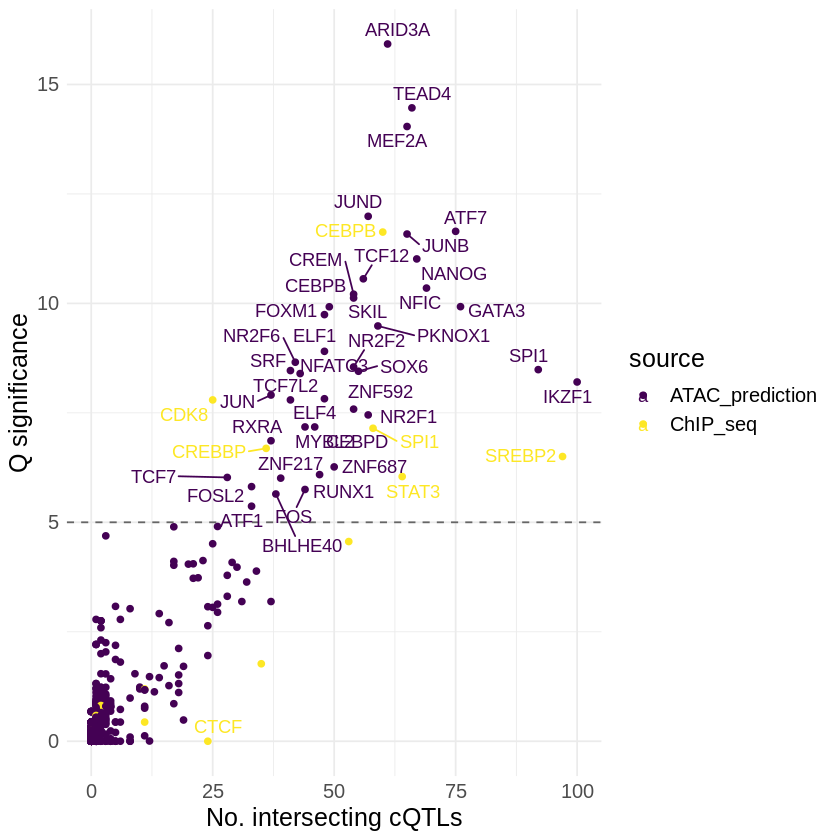

In [7]:
### Looking in 2 categories, preicted or binding
### First looking at results from the quick and dirty approach: combining the tables.

chipqad <- fread("./Rev/GUESS_BASE_vUniverseSNPs_monoChIP_shuffles100_2Cats.txt")
chipqad[, nb.overlaps := as.numeric(nb.overlaps)]

### this data is from four sources: maxatac, chip, tobias, remapmono
head(chipqad)

chipqad_plot <- chipqad[!is.na(q.significance)]
nrow(chipqad_plot)
nrow(chipqad_plot)

### Sort out the source and TF names
chipqad_plot[, c("tf", "source") := tstrsplit(category, split = ":")]
chipqad_plot[nb.overlaps >= 5 & q.significance > 5, TF := tf]
chipqad_plot[tf == "CTCF", TF := "CTCF"]
chipqad_plot[is.na(TF), TF := ""]

###

# want to show how many TFs were included in the analysis.
print(paste0("No. of significant TFs in chip intersect is ", length(unique(chipqad_plot[q.significance > 5 & nb.overlaps >=5, tf])))) # 43
chipqad_plot[category %like% "CTCF"]
chipqad_plot[category %like% "SPI1"]


############ Plot the results

# p.significance is same as -log10p
# q.significance is FDR
p <- ggplot(chipqad_plot, aes(x = nb.overlaps, y = q.significance, color = source, label = TF)) + geom_point() + 
xlab("No. intersecting cQTLs") + 
ylab("Q significance")


pdf(file = "./mono_overlaps_fig_plot_minOverlaps5_2Cats.pdf")
print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     scale_color_viridis_d() + 
     geom_text_repel() + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))
dev.off()

print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     scale_color_viridis_d() + 
     geom_text_repel() + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))


# look into merging them properly!

#### Now finally using the regions fully merged between sources per TF.
#### This is the plot in Fig. 6 in the paper.

[1] 716

[1] 641

[1] 641

[1] "No. of significant TFs in chip intersect is 43"


png 
  2

category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value,source,tf,TF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ChIP_STAT3,64,29.47,7.299104e-04,1.118825,7.952335,1.116001e-08,6.3130671,4.863320e-07,5.0925968,8.079848e-06,ChIP,STAT3,STAT3
ATAC_STAT3,1,0.11,9.260117e-05,3.184425,2.249946,5.624110e-03,0.8735875,1.337866e-01,-0.6097924,4.071856e+00,ATAC,STAT3,


category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value,source,tf,TF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ChIP_SREBP2,93,51.17,0.001325107,0.8619325,7.281539,5.229507e-08,5.667095,2.152313e-06,4.421801,3.786163e-05,ChIP,SREBP2,SREBP2


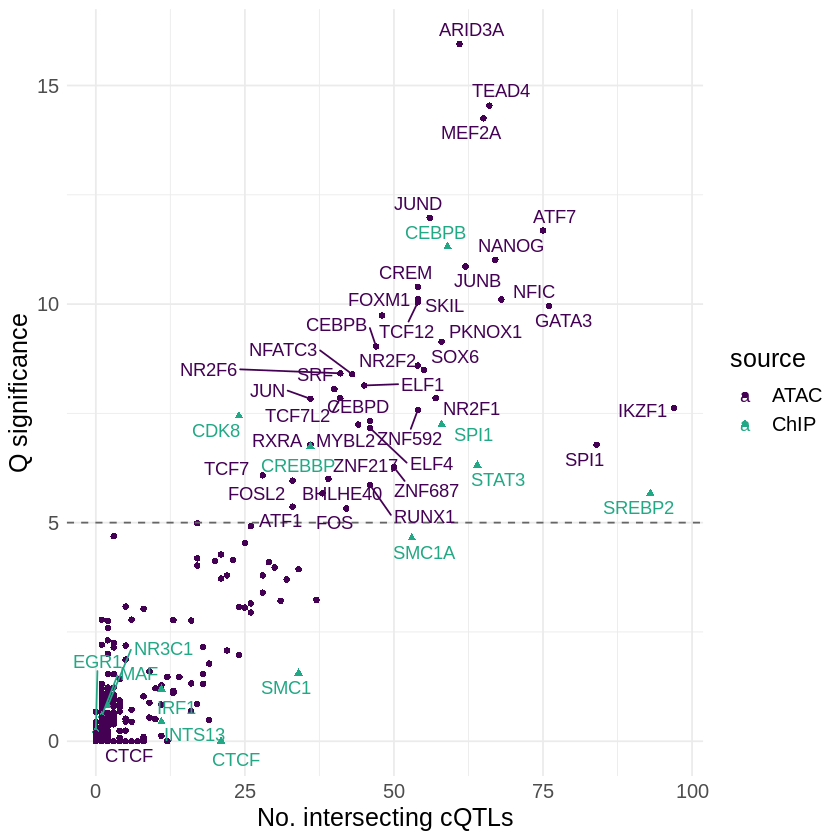

In [14]:

### now looking at the proper merging.

chippro <- fread("./Rev/GUESS_BASE_vUniverseSNPs_monoChIP_shuffles100_2Cats_merged.txt")
chippro[, nb.overlaps := as.numeric(nb.overlaps)]

### this data is from four sources: maxatac, chip, tobias, remapmono
#head(chippro)
chippro[, c("source", "tf") := tstrsplit(category, split = "_")]
length(unique(chippro$tf))

chippro_plot <- chippro[!is.na(q.significance)]
nrow(chippro_plot)
nrow(chippro_plot)

### Sort out the source and TF names
chippro_plot[, c("source", "tf") := tstrsplit(category, split = "_")]
chippro_plot[nb.overlaps >= 5 & q.significance > 5, TF := tf]
chippro_plot[tf == "CTCF", TF := "CTCF"]
chippro_plot[is.na(TF), TF := ""]
fwrite(unique(chippro_plot[, .(TF)]), file = "mono_TFs_for_STRING.txt", sep = "\t", quote = F, row.names = F, col.names = F) # but remove CTCF!


###

# want to show how many TFs were included in the analysis.
print(paste0("No. of significant TFs in chip intersect is ", length(unique(chippro_plot[q.significance > 5 & nb.overlaps >=5, tf])))) # 43
#chippro_plot[category %like% "CTCF"]
#chippro_plot[category %like% "SPI1"]


############ Plot the results

# p.significance is same as -log10p
# q.significance is FDR
p <- ggplot(chippro_plot, aes(x = nb.overlaps, y = q.significance, color = source, shape = source, label = TF)) + geom_point() + 
xlab("No. intersecting cQTLs") + 
ylab("Q significance")

### try labelling all the chip seq too.
chippro_plot[category %like% "ChIP", TF := tf]

pdf(file = "./mono_overlaps_fig_plot_minOverlaps5_2Cats_merged.pdf", width = 6, height = 7)
print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     scale_color_viridis_d(begin = 0, end = 0.6) + 
     geom_text_repel(max.overlaps = 1000) + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))
dev.off()

print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     scale_color_viridis_d(begin = 0, end = 0.6) + 
     geom_text_repel(max.overlaps = 1000) + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))


# Now numbers are correct against the intersects for Enformer/DeepSea.



chippro_plot[tf == "STAT3"] # check the input here, atac is really bad. i think bec no maxATAC
chippro_plot[tf == "SREBP2"] # there is no atac for this tf




In [5]:
intersects4mikhail <- fread("~/HRJ_monocytes/machine_learning/Rev/QTL_intersect_with_Remap_Tob_Max_ChIP.txt")
#head(intersects4mikhail)

intersects4mikhail <- intersects4mikhail[QTLtype == "cQTL"]
ctcf_mik_ChIP <- intersects4mikhail[TF == "CTCF" & Source == "Remap_mono" | TF == "CTCF" & Source == "CTCF_ChIP"]
length(unique(ctcf_mik_ChIP$rsid)) # 21
ctcf_mik_ChIP
# in the fig it is 23 for ChIP and lower for ATAC

chippro[tf == "CTCF"] # 21 for ChIP, correct

ctcf_mik_ATAC <- intersects4mikhail[TF == "CTCF" & Source == "maxATAC_peak" | TF == "CTCF" & Source == "TOBIAS_FP"]
length(unique(ctcf_mik_ATAC$rsid)) # 7, correct
ctcf_mik_ATAC

chippro[tf == "CTCF"]

# qad was double counting
chipqad <- fread("./Rev/GUESS_BASE_vUniverseSNPs_monoChIP_shuffles100_2Cats.txt")
chipqad[, nb.overlaps := as.numeric(nb.overlaps)]
chipqad[, c("tf", "source") := tstrsplit(category, split = ":")]

chipqad[tf == "CTCF"] # here it is 32... due to double counting...

intersects4mikhail[TF == "STAT3"]

##### D) plot the ATAC predictions alone.
##### I thought about using this plot, but in losing the monocyte ChIP-seq (merged peaks) we lose a lot of information.

[1] 710

[1] 153

[1] 153

[1] "No. of significant TFs in ATAC prediction intersect is 48"


category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value,source,tf,TF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ATAC_CTCF,11,8.03,0.0002657647,0.4540316,0.9427072,0.1141019,0.07261308,0.8460323,-1.908551,81.01233,ATAC,CTCF,CTCF


category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value,source,tf,TF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ATAC_SPI1,114,60.26,0.001056877,0.9197612,9.619182,2.403356e-10,8.674454,2.116147e-09,6.767924,1.706383e-07,ATAC,SPI1,SPI1


png 
  2

category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value,source,tf,TF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>


category,nb.overlaps,random.average,mapped.peaks.ratio,effect.size,p.significance,p.value,q.significance,q.value,e.significance,e.value,source,tf,TF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>


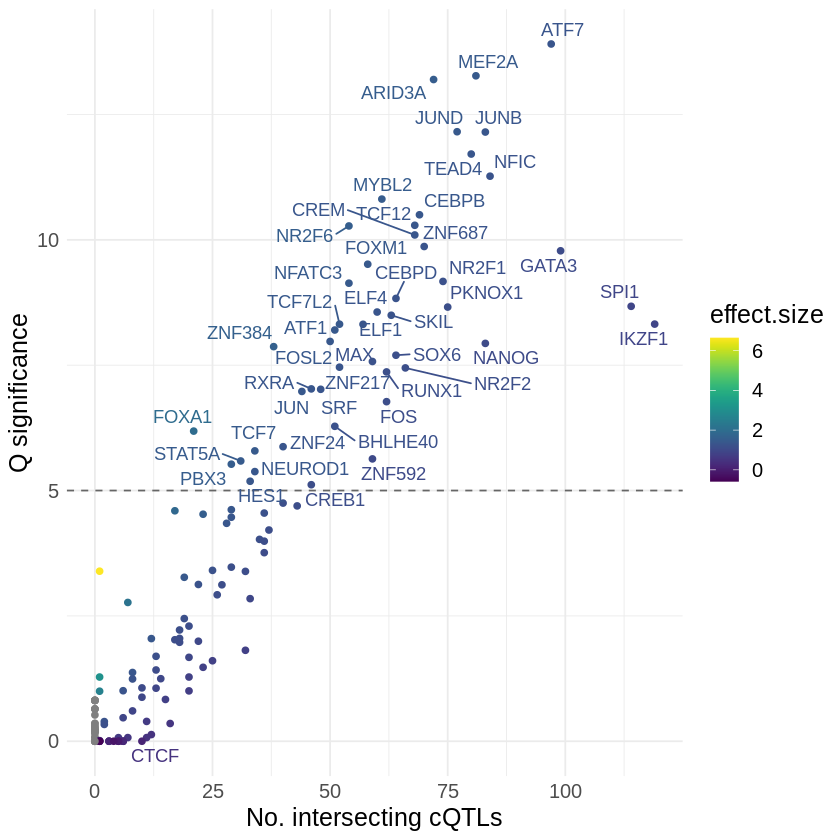

In [10]:
library(viridis)

### now looking at the proper merging.

chippro <- fread("./Rev/GUESS_BASE_vUniverseSNPs_monoChIP_shuffles100_2Cats_merged_ATAC_category.txt")
chippro[, nb.overlaps := as.numeric(nb.overlaps)]

### this data is from two sources: maxatac, tobias
#head(chippro)
chippro[, c("source", "tf") := tstrsplit(category, split = "_")]
length(unique(chippro$tf))

chippro_plot <- chippro[!is.na(q.significance)]
nrow(chippro_plot)
nrow(chippro_plot)

### Sort out the source and TF names
chippro_plot[nb.overlaps >= 5 & q.significance > 5, TF := tf]
chippro_plot[tf == "CTCF", TF := "CTCF"]
chippro_plot[is.na(TF), TF := ""]
fwrite(unique(chippro_plot[, .(TF)]), file = "mono_TFs_ATAC_only_for_STRING.txt", sep = "\t", quote = F, row.names = F, col.names = F) # but remove CTCF!


###

# want to show how many TFs were included in the analysis.
print(paste0("No. of significant TFs in ATAC prediction intersect is ", length(unique(chippro_plot[q.significance > 5 & nb.overlaps >=5, tf])))) # 48
chippro_plot[category %like% "CTCF"]
chippro_plot[category %like% "SPI1"]

############ Plot the results

# p.significance is same as -log10p
# q.significance is FDR
p <- ggplot(chippro_plot, aes(x = nb.overlaps, y = q.significance, color = effect.size, label = TF)) + geom_point() + 
scale_color_viridis() + 
xlab("No. intersecting cQTLs") + 
ylab("Q significance")

### try labelling all the chip seq too.
chippro_plot[category %like% "ChIP", TF := tf]

pdf(file = "./mono_overlaps_fig_plot_minOverlaps5_2Cats_merged_ATAC_only.pdf", width = 6, height = 7)
print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     geom_text_repel(max.overlaps = 1000) + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))
dev.off()



print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     geom_text_repel(max.overlaps = 1000) + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))


# Now numbers are correct against the intersects for Enformer/DeepSea.



chippro_plot[tf == "STAT3"] # check the input here, atac is really bad. i think bec no maxATAC
chippro_plot[tf == "SREBP2"] # there is no atac for this tf

##### 3. Make plot for whole remap intersect. This one will be for suppl. fig.
##### plot same as for above but all cell types.

[1] 1426916

[1] 29973

png 
  2

png 
  2

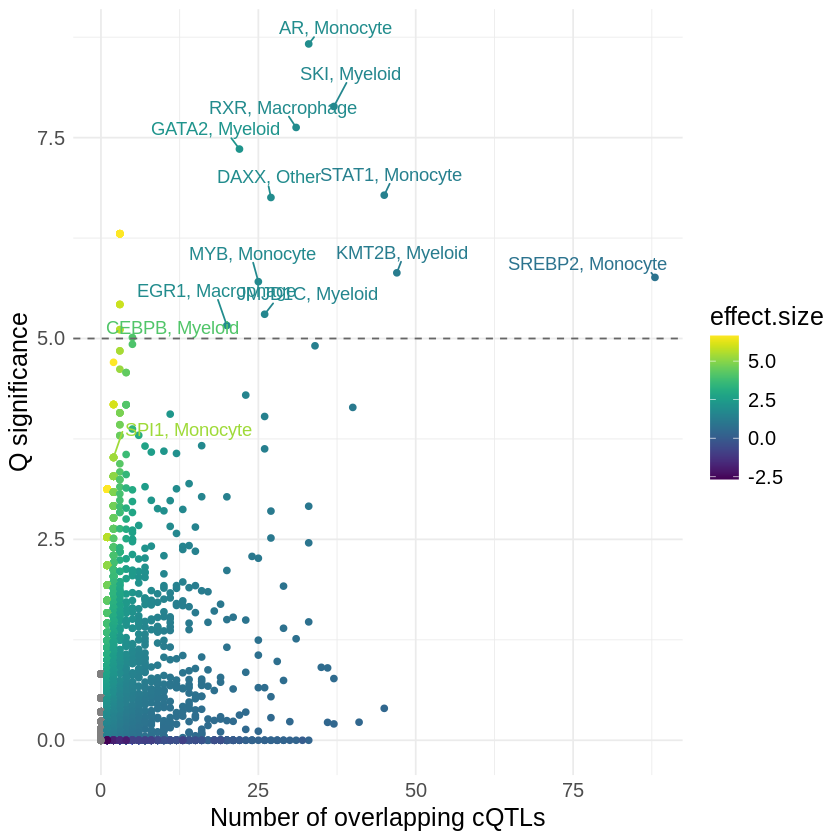

In [6]:
library(viridis)

remap <- fread("./Rev/GUESS_BASE_vUniverseSNPs_remap_shuffles100.txt")
remap[, nb.overlaps := as.numeric(nb.overlaps)]

remap_plot <- remap[!is.na(q.significance)]
nrow(remap)
nrow(remap_plot)

### Sort out the source and TF names
remap_plot[, c("tf", "source") := tstrsplit(category, split = ":")]

### can't color by cell type bc too many and idk how to find all the myeloid, mono, mac etc
### for now look at non cell specific
# to fix the below for labels!!
#remap_plot[nb.overlaps > 10 | q.significance > 5 | nb.overlaps >=2 & effect.size > 5, TF := tf] # effect.size > 5 to get SPI1

### assign cell types

remap_plot[category %like% "THP-1", cell_type := "Monocyte"]
remap_plot[category %like% "CD14", cell_type := "Monocyte"]
remap_plot[category %like% "monocyte", cell_type := "Monocyte"]
remap_plot[category %like% "HL-60", cell_type := "Myeloid"]
remap_plot[category %like% "SKH1", cell_type := "Myeloid"]
remap_plot[category %like% "AML", cell_type := "Myeloid"]
remap_plot[category %like% "macrophage", cell_type := "Macrophage"]
remap_plot[is.na(cell_type), cell_type := "Other"]

### Make names for sig TFs and also SPI1
remap_plot[q.significance > 5, TF_celltype := paste(tf, cell_type, sep = ", ")]
remap_plot[tf %like% "SPI1" & q.significance > 3.5, TF_celltype := "SPI1, Monocyte"] # to get top SPI1
remap_plot[is.na(TF_celltype), TF_celltype := ""]

remap_plot[tf %like% "SPI1" & q.significance > 3.5, TF_celltype5 := "SPI1, Monocyte"] # to get top SPI1
remap_plot[q.significance > 5 & nb.overlaps >= 5, TF_celltype5 := paste(tf, cell_type, sep = ", ")]
remap_plot[is.na(TF_celltype5), TF_celltype5 := ""]


# p.significance is same as -log10p
# q.significance is FDR
p <- ggplot(remap_plot, aes(x = effect.size, y = q.significance, color = nb.overlaps)) + 
geom_point() + 
xlab("Effect size") + 
ylab("Q significance") +
geom_text_repel(aes(label = TF_celltype), min.segment.length = 0, box.padding = 0.5, max.overlaps = Inf, 
                position = position_nudge_repel(x = 0.1, y = 0.15)) +
xlim(-5, 10)

pdf(file = "./remap_overlaps_fig_plot_noMinOverlaps.pdf")
print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     scale_color_viridis_c() + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))
dev.off()


# 5 overlaps min
p <- ggplot(remap_plot, aes(x = nb.overlaps, y = q.significance, color = effect.size)) + 
     scale_color_viridis() + 
geom_point() + 
xlab("Number of overlapping cQTLs") + 
ylab("Q significance") +
geom_text_repel(aes(label = TF_celltype5), min.segment.length = 0, box.padding = 0.5, max.overlaps = Inf, 
                position = position_nudge_repel(x = 0.1, y = 0.15))

pdf(file = "./remap_overlaps_fig_plot_MinOverlaps5.pdf")
print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))
dev.off()

print(p + geom_hline(yintercept = 5, linetype = "dashed", color = "gray40") + 
     theme_minimal() + 
     theme(text = element_text(size = 15)))

## Effect size is the log ratio between the observed and expected number of overlaps.




4. Reporting the stats. How many were significant in each?


In [23]:
print(paste0("No. of TFs in remap intersect is ", length(unique(remap_plot$tf))))
print(paste0("No. of significant TFs in remap intersect is ", length(unique(remap_plot[q.significance > 5 & nb.overlaps >=5, tf]))))

# want to show how many cell types were included in the analysis.
remap_plot2 <- as.data.table(remap_plot %>% separate_rows(source, sep = ","))
print(paste0("No. of cell types in remap intersect is ", length(unique(remap_plot2$source))))
print(paste0("No. of significant cell types in remap intersect is ", length(unique(remap_plot2[q.significance > 5 & nb.overlaps >=5, source])))) 
#remap_plot[q.significance > 5 & nb.overlaps >=5, category]


print(paste0("No. of TFs in chip intersect is ", length(unique(chippro_plot$tf))))
print(paste0("No. of significant TFs in chip intersect is ", length(unique(chippro_plot[q.significance > 5 & nb.overlaps >=5, tf]))))

# want to show how many cell types were included in the analysis.
chip_plot2 <- as.data.table(chippro_plot %>% separate_rows(source, sep = ","))
print(paste0("No. of cell types in chip intersect is ", length(unique(chip_plot2$source))))
print(paste0("No. of significant cell types in chip intersect is ", length(unique(chip_plot2[q.significance > 5 & nb.overlaps >=5, source]))))

# which ones were sig in both chip and ATAC predictions in monocytes?
sig <- unique(chip_plot2[q.significance > 5 & nb.overlaps >=5, .(TF, source)])
sig[which(duplicated(TF))] # only CEBPB and SPI1

[1] "No. of TFs in remap intersect is 1171"
[1] "No. of significant TFs in remap intersect is 12"
[1] "No. of cell types in remap intersect is 726"
[1] "No. of significant cell types in remap intersect is 9"
[1] "No. of TFs in chip intersect is 633"
[1] "No. of significant TFs in chip intersect is 43"
[1] "No. of cell types in chip intersect is 2"
[1] "No. of significant cell types in chip intersect is 2"


TF,source
<chr>,<chr>
CEBPB,ATAC
SPI1,ATAC


In [25]:
chippro_plot_sig <- chippro_plot[q.significance > 5 & nb.overlaps >=5]
chippro_plot_wide <- dcast(chippro_plot_sig, formula = TF ~ source)
#chippro_plot_wide

unique(chippro_plot_wide[!is.na(ATAC), TF])
unique(chippro_plot_wide[!is.na(ChIP), TF])

Using 'TF' as value column. Use 'value.var' to override



[1] "ARID3A"  "ATF1"    "ATF7"    "BHLHE40" "CEBPB"   "CEBPD"   "CREM"   
 [8] "ELF1"    "ELF4"    "FOS"     "FOSL2"   "FOXM1"   "GATA3"   "IKZF1"  
[15] "JUN"     "JUNB"    "JUND"    "MEF2A"   "MYBL2"   "NANOG"   "NFATC3" 
[22] "NFIC"    "NR2F1"   "NR2F2"   "NR2F6"   "PKNOX1"  "RUNX1"   "RXRA"   
[29] "SKIL"    "SOX6"    "SPI1"    "SRF"     "TCF12"   "TCF7"    "TCF7L2" 
[36] "TEAD4"   "ZNF217"  "ZNF592"  "ZNF687"

[1] "CDK8"   "CEBPB"  "CREBBP" "SPI1"   "SREBP2" "STAT3"

In [58]:
tosave <- unique(chip_plot[q.significance > 5 & nb.overlaps > 5, TF])

tosave

[1] "ARID3A"  "TEAD4"   "MEF2A"   "JUND"    "ATF7"    "NANOG"   "JUNB"   
 [8] "CREM"    "TCF12"   "NFIC"    "SKIL"    "GATA3"   "FOXM1"   "PKNOX1" 
[15] "CEBPB"   "NR2F6"   "NR2F2"   "SOX6"    "NFATC3"  "ELF1"    "SRF"    
[22] "NR2F1"   "TCF7L2"  "IKZF1"   "JUN"     "ZNF592"  "ELF4"    "MYBL2"  
[29] "CEBPD"   "SPI1"    "ZNF687"  "TCF7"    "RXRA"    "FOSL2"   "ZNF217" 
[36] "RUNX1"   "BHLHE40" "ATF1"    "FOS"     "SREBP2"  "FOXA1"   "NEUROD1"
[43] "HES1"    "PBX3"